This is the second pratice code for the application of Double Machine Learning (DML) to estimate the effect of 401(k) participation on retirement savings. The 401K data considered here is from the Survey of Income and Program Participation (SIPP) from the year 1991. We use the data taken from the application in Chernozhukov et al. (2018). This time we play around with different models and compare the results. 
401(k) plans are pension accounts sponsored by employers. A major challenge in assessing the impact of participating in 401(k) plans on accumulated savings arises from saver heterogeneity and the non-random nature of enrollment decisions. Individuals differ significantly in their intrinsic preferences for saving, and it is reasonable to assume that those with stronger, unobserved preferences for saving are more inclined to participate in tax-advantaged retirement plans such as 401(k)s. Consequently, these individuals likely have higher accumulated assets regardless of participation. Failure to account for this saver heterogeneity and the endogenous nature of participation decisions leads to upward-biased estimates, overstating the actual savings effects attributable to 401(k) participation.

To address this bias, it can be argued that eligibility for enrolling in a 401(k) plan can be considered exogenous once certain observable factors, especially income, are controlled for. This argument rests on the premise that when 401(k) plans were initially introduced, employment decisions were generally driven by income and other job characteristics, rather than by the availability of a 401(k). Thus, after conditioning on income and similar observables, eligibility for a 401(k) is less likely to be correlated with unobserved preferences for saving.- source:https://docs.doubleml.org/dev/examples/py_double_ml_pension.html

We use net financial assets (net_tfa) as the outcome variable. The treatment variable is 401(k) participation (p401k). The covariates are age, income, education, marital status and other worker characteristics. The variable e401 indicates eligibility and p401 indicates participation in 401(k) plan.

In [2]:
import numpy as np
import pandas as pd
# Load the dataset
data = pd.read_stata('/Users/prachijhamb/Downloads/sipp1991.dta')
data.head()
print(data.describe())

               nifa       net_tfa            tw          age            inc  \
count  9.915000e+03  9.915000e+03  9.915000e+03  9915.000000    9915.000000   
mean   1.392864e+04  1.805153e+04  6.381685e+04    41.060212   37200.621094   
std    5.490504e+04  6.352259e+04  1.115296e+05    10.344505   24774.251953   
min    0.000000e+00 -5.023020e+05 -5.023020e+05    25.000000   -2652.000000   
25%    2.000000e+02 -5.000000e+02  3.291500e+03    32.000000   19413.000000   
50%    1.635000e+03  1.499000e+03  2.510000e+04    40.000000   31476.000000   
75%    8.765500e+03  1.652450e+04  8.148750e+04    48.000000   48583.500000   
max    1.430298e+06  1.536798e+06  2.029910e+06    64.000000  242124.000000   

             fsize         educ           db         marr      twoearn  \
count  9915.000000  9915.000000  9915.000000  9915.000000  9915.000000   
mean      2.865860    13.206253     0.271004     0.604841     0.380837   
std       1.538937     2.810382     0.444500     0.488909     0.48

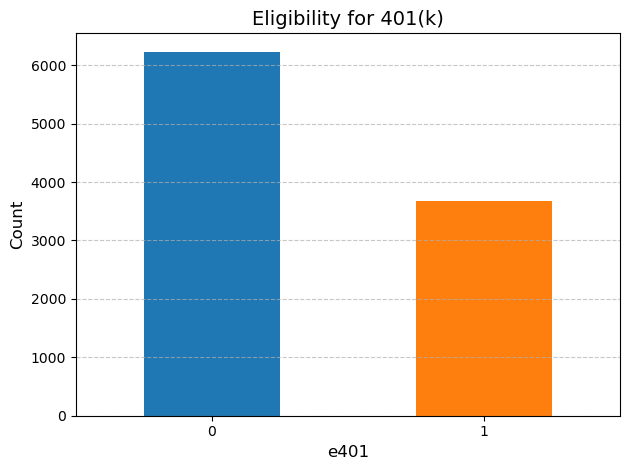

In [ ]:
#Create a bar plot of the variable e401, which represents the eligibility for 401(k) plans. The variable e401 has two values: 1 if the respondent is eligible for a 401(k) plan and 0 otherwise.
# Define colors explicitly
colors = ['#1f77b4', '#ff7f0e']

import matplotlib.pyplot as plt
# Set matplotlib attribute to plot the graph inline
%matplotlib inline
# Plotting
data['e401'].value_counts().plot(kind='bar', color=colors)
plt.title('Eligibility for 401(k)', fontsize=14)
plt.xlabel('e401', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
#Run OLS for the linear model


Linear model in Strategy 1 gives us the ATE estimate of about 5K, while Strateg 2 (DML-PLM) gives that ATE estimate of about 8K. Thus, OLS-LM understates the ATE effect by roughly 30% in relative terms.

Since DML-PLM in Strategy 2 is strictly more general than the LM in Strategy 1, we realize that the basic linear model is a pretty bad model in this example.

In summary, we've used DML-PLM to validate the simple linear model and ended up rejecting it as not very sensible. Here we can just go ahead and use DML-PLM model.